In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Integrate and view the datset supply chain and remove the columns that are not required

df = pd.read_csv("supply_chain_project_trustpilot_advanced_merge.csv")
df.head()


,Unnamed: 0,Company,Name,Rating_number_customer,Heading,Comment,Stars,Invitation,Dates
0,0,skatedeluxe,Sandra,2,Jederzeit wieder,"<p class=""typography_body-l__v5JLj typography_...",5,Auf Einladung,5. März 2025
1,1,skatedeluxe,customer,2,Schnelle Lieferung,No comment,5,Auf Einladung,5. März 2025
2,2,skatedeluxe,Dexter,1,Bester Service und top Qualität,"<p class=""typography_body-l__v5JLj typography_...",5,Auf Einladung,4. März 2025
3,3,skatedeluxe,Stephan Lameck,1,Schnelligkeit,"<p class=""typography_body-l__v5JLj typography_...",5,Auf Einladung,4. März 2025
4,4,skatedeluxe,Fritz Brack,2,Super Service,"<p class=""typography_body-l__v5JLj typography_...",5,Auf Einladung,3. März 2025


In [2]:
display(df.describe())
display(df.info())

,Unnamed: 0,Rating_number_customer,Stars
count,18378.000000,18378.000000,18378.000000
mean,9188.500000,3.602079,3.611927
std,5305.415959,6.258368,1.768108
min,0.000000,1.000000,1.000000
25%,4594.250000,1.000000,1.000000
50%,9188.500000,2.000000,5.000000
75%,13782.750000,4.000000,5.000000
max,18377.000000,263.000000,5.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18378 entries, 0 to 18377
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              18378 non-null  int64 
 1   Company                 18378 non-null  object
 2   Name                    18375 non-null  object
 3   Rating_number_customer  18378 non-null  int64 
 4   Heading                 18378 non-null  object
 5   Comment                 18378 non-null  object
 6   Stars                   18378 non-null  int64 
 7   Invitation              18378 non-null  object
 8   Dates                   18378 non-null  object
dtypes: int64(3), object(6)
memory usage: 1.3+ MB


None

In [3]:
# Print the first 5 comments in full
for comment in df['Comment'].head(5):
    print(comment)
    print('-' * 80)  

<p class="typography_body-l__v5JLj typography_appearance-default__t8iAq" data-service-review-text-typography="true">Sehr schnelle Lieferung, gutes Preis-Leistungsverhältnis.</p>
--------------------------------------------------------------------------------
No comment
--------------------------------------------------------------------------------
<p class="typography_body-l__v5JLj typography_appearance-default__t8iAq" data-service-review-text-typography="true">Der bestellvorgang war unkompliziert, <br/>Die gewünschten Produkte kamen schnell und entsprechen der zu erwartenden Qualität,<br/> Immer wieder gern 👍✌️</p>
--------------------------------------------------------------------------------
<p class="typography_body-l__v5JLj typography_appearance-default__t8iAq" data-service-review-text-typography="true">Ausgefallene Produkte</p>
--------------------------------------------------------------------------------
<p class="typography_body-l__v5JLj typography_appearance-default__t8iAq

In [4]:
# Define a function to clean each comment
def extract_comment(text):
    if isinstance(text, str):
        # Find text between the first ">" and the next "<"
        matches = re.findall(r'>([^<]+)<', text)
        if matches:
            return matches[0]
    return text  # If not a string or no match, return as is

# Apply the cleaning function to the Comment column
df['Comment'] = df['Comment'].apply(extract_comment)

# Now check the first 5 cleaned comments
for comment in df['Comment'].head(5):
    print(comment)
    print('-' * 80)

Sehr schnelle Lieferung, gutes Preis-Leistungsverhältnis.
--------------------------------------------------------------------------------
No comment
--------------------------------------------------------------------------------
Der bestellvorgang war unkompliziert, 
--------------------------------------------------------------------------------
Ausgefallene Produkte
--------------------------------------------------------------------------------
Super Service, extrem schnelle Lieferung, Top Qualität zu super Preisen
--------------------------------------------------------------------------------


In [5]:
# 1. Merge 'Heading' and 'Comment' into a new column called 'Text'
df['Text'] = (df['Heading'].fillna('') + ' ' + df['Comment'].fillna('')).str.strip()

# 2. Drop columns Name, Heading, Comment
df = df.drop(columns=['Name', 'Heading', 'Comment'], axis=1)

# 3. Display the first few rows to check
df.head()


,Unnamed: 0,Company,Rating_number_customer,Stars,Invitation,Dates,Text
0,0,skatedeluxe,2,5,Auf Einladung,5. März 2025,"Jederzeit wieder Sehr schnelle Lieferung, gute..."
1,1,skatedeluxe,2,5,Auf Einladung,5. März 2025,Schnelle Lieferung No comment
2,2,skatedeluxe,1,5,Auf Einladung,4. März 2025,Bester Service und top Qualität Der bestellvor...
3,3,skatedeluxe,1,5,Auf Einladung,4. März 2025,Schnelligkeit Ausgefallene Produkte
4,4,skatedeluxe,2,5,Auf Einladung,3. März 2025,"Super Service Super Service, extrem schnelle L..."


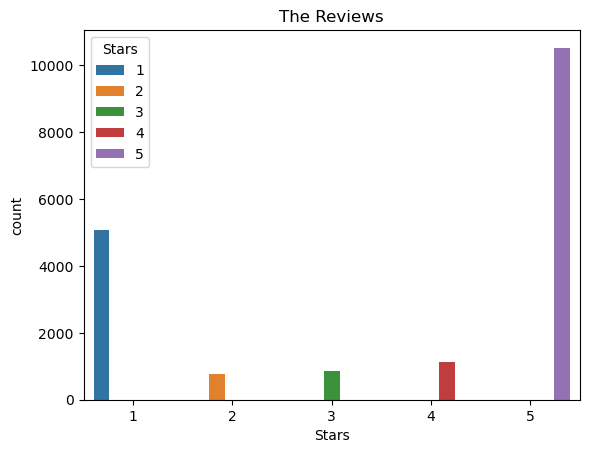

In [6]:
# A plot to better see the weighting of the individual values.

sns.countplot(x=df['Stars'], hue=df['Stars'])
plt.title('The Reviews')
plt.show()

In [7]:
df['Stars'].value_counts()

Stars
5    10523
1     5086
4     1134
3      873
2      762
Name: count, dtype: int64

In [8]:
# The rows 2, 3, 4 in the Stars column are deleted for better training and your better evaluation. Or not?
# this will be addressed later in the workflow by using oversampling
# oversampling can only be done on the train, i.e. after the train test split, to avoid data leakage

In [9]:
# The next step is to remove regular expressions and pop words that are not relevant.
# Output some sentences
df['Text'].head(20)

0     Jederzeit wieder Sehr schnelle Lieferung, gute...
1                         Schnelle Lieferung No comment
2     Bester Service und top Qualität Der bestellvor...
3                   Schnelligkeit Ausgefallene Produkte
4     Super Service Super Service, extrem schnelle L...
5     Lieferung super schnell und Retoure war… Liefe...
6     Die Ware hat eine sehr hohe Qualität ! Die War...
7     zuverlässig zuverlässig, superschneller Versan...
8     Stets gute Preise und tolle Aktionen Stets gut...
9     Super Schnelle Lieferung und guter… Super Schn...
10    Gute Ware zu gutem Preis! Gute Ware zu gutem P...
11    Schnelle Lieferung Schnelle Lieferung, tolles ...
12    Nach anfänglichen lieferproblemen hat… Nach an...
13    Alles tutti Von der Bestellung bis zur Lieferu...
14    Lieferung,Qualität und Verpackung Top! Lieferu...
15    Schneller Versand und top Ware Alles bestens w...
16    Sehr wackelig aber nach dem Fest ziehen… Sehr ...
17    Super schnelle Lieferung Super schnelle Li

In [10]:
print("There are exclamation marks, but there are no more special characters.")

There are exclamation marks, but there are no more special characters.


In [11]:
# We put the text in lower case
df["Text"] = df["Text"].str.lower()

# the Text column is incorrectly formatted
from bs4 import BeautifulSoup

# Define a function to clean HTML
def clean_html(text):
    if isinstance(text, str):
        return BeautifulSoup(text, "html.parser").get_text()
    else:
        return ""

# Apply it to your 'Text' column
df['Text'] = df['Text'].apply(clean_html)

# check if it worked
df["Text"].head(20)

/tmp/ipykernel_4776/4169933976.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


0     jederzeit wieder sehr schnelle lieferung, gute...
1                         schnelle lieferung no comment
2     bester service und top qualität der bestellvor...
3                   schnelligkeit ausgefallene produkte
4     super service super service, extrem schnelle l...
5     lieferung super schnell und retoure war… liefe...
6     die ware hat eine sehr hohe qualität ! die war...
7     zuverlässig zuverlässig, superschneller versan...
8     stets gute preise und tolle aktionen stets gut...
9     super schnelle lieferung und guter… super schn...
10    gute ware zu gutem preis! gute ware zu gutem p...
11    schnelle lieferung schnelle lieferung, tolles ...
12    nach anfänglichen lieferproblemen hat… nach an...
13    alles tutti von der bestellung bis zur lieferu...
14    lieferung,qualität und verpackung top! lieferu...
15    schneller versand und top ware alles bestens w...
16    sehr wackelig aber nach dem fest ziehen… sehr ...
17    super schnelle lieferung super schnelle li

In [12]:
# replace missing values
df['Text'] = df['Text'].fillna('')
df['Text'] = df['Text'].astype(str)
# tokenize
df["Text"] = df["Text"].apply(word_tokenize)
df.head()

,Unnamed: 0,Company,Rating_number_customer,Stars,Invitation,Dates,Text
0,0,skatedeluxe,2,5,Auf Einladung,5. März 2025,"[jederzeit, wieder, sehr, schnelle, lieferung,..."
1,1,skatedeluxe,2,5,Auf Einladung,5. März 2025,"[schnelle, lieferung, no, comment]"
2,2,skatedeluxe,1,5,Auf Einladung,4. März 2025,"[bester, service, und, top, qualität, der, bes..."
3,3,skatedeluxe,1,5,Auf Einladung,4. März 2025,"[schnelligkeit, ausgefallene, produkte]"
4,4,skatedeluxe,2,5,Auf Einladung,3. März 2025,"[super, service, super, service, ,, extrem, sc..."


In [13]:
# Initialize empty words variable
# The applying from stopwrods filter on the text corpus.
# correct in german !!!
stop_words = set(stopwords.words('german'))
print(stop_words)

{'denn', 'zwischen', 'da', 'demselben', 'könnte', 'habe', 'eurem', 'einigem', 'jenes', 'euren', 'ihres', 'meinen', 'ihrer', 'eines', 'einmal', 'kein', 'solche', 'es', 'solchem', 'würden', 'welchen', 'nach', 'und', 'dessen', 'manche', 'ob', 'vom', 'wollte', 'die', 'gewesen', 'mir', 'auch', 'jene', 'unser', 'mich', 'alles', 'selbst', 'war', 'meinem', 'an', 'dann', 'so', 'wo', 'wollen', 'können', 'diese', 'hatten', 'soll', 'weil', 'der', 'jedem', 'machen', 'meine', 'bist', 'ich', 'allen', 'jeder', 'werden', 'deinem', 'wenn', 'also', 'bei', 'welche', 'sonst', 'dieses', 'dieselbe', 'euer', 'einiger', 'weiter', 'welcher', 'zur', 'sein', 'kann', 'über', 'viel', 'zu', 'diesem', 'seinen', 'deinen', 'ihrem', 'ist', 'nicht', 'unserem', 'während', 'uns', 'dieselben', 'ihren', 'jeden', 'jetzt', 'jenem', 'nun', 'hab', 'nur', 'dasselbe', 'bis', 'dir', 'in', 'mancher', 'solches', 'einem', 'unsere', 'aus', 'dass', 'hin', 'meines', 'musste', 'welchem', 'du', 'keines', 'gegen', 'um', 'ins', 'hatte', 'doc

In [14]:
# Add to the list of stopwords the syntax elements we have identified that are not useful for text analysis
# The special characters, punctuation will add to the stop_words set.
# Define the stop_words_filtering function

new_stop_words = [",", ".", "``", "@", "*", "(", ")", "§", "$", "&", "€", "...", "!", "?", "-", "_", ">", "<", ":", "/", "=", "--", "©", "~", ";", "\\", "\\\\"]
 
stop_words.update(new_stop_words)

def stop_words_filtering(words) : 
    tokens = []
    for word in words:
        if word not in stop_words:
            tokens.append(word)
    return tokens

df["Text"] = df["Text"].apply(stop_words_filtering)
df['Text'].head(20)


0     [jederzeit, schnelle, lieferung, gutes, preis-...
1                    [schnelle, lieferung, no, comment]
2     [bester, service, top, qualität, bestellvorgan...
3               [schnelligkeit, ausgefallene, produkte]
4     [super, service, super, service, extrem, schne...
5     [lieferung, super, schnell, retoure, war…, lie...
6          [ware, hohe, qualität, ware, hohe, qualität]
7     [zuverlässig, zuverlässig, superschneller, ver...
8     [stets, gute, preise, tolle, aktionen, stets, ...
9     [super, schnelle, lieferung, guter…, super, sc...
10    [gute, ware, gutem, preis, gute, ware, gutem, ...
11    [schnelle, lieferung, schnelle, lieferung, tol...
12    [anfänglichen, lieferproblemen, hat…, anfängli...
13    [tutti, bestellung, lieferung, lief, perfekt, ...
14    [lieferung, qualität, verpackung, top, lieferu...
15      [schneller, versand, top, ware, bestens, immer]
16    [wackelig, fest, ziehen…, wackelig, fest, zieh...
17    [super, schnelle, lieferung, super, schnel

In [15]:


# The following block is used to ensure stopwords are filtered
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

# Make sure it's a string
df['Text'] = df['Text'].astype(str)

# Tokenize the sentences
df['Text'] = df['Text'].apply(word_tokenize)

# Remove stopwords (German stopwords)
stop_words = set(stopwords.words('german'))

def stop_words_filtering(words):
    tokens = []
    for word in words:
        if word.lower() not in stop_words:
            tokens.append(word)
    return tokens

df['Text'] = df['Text'].apply(stop_words_filtering)

# Join the tokens back to strings and view the result
df['Text'] = df['Text'].apply(lambda x: ''.join(x))
df['Text'].head(20)



[nltk_data] Downloading package punkt to
[nltk_data]     /home/f7984027-8341-4813-a985-
[nltk_data]     c30afa0dff71/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/f7984027-8341-4813-a985-
[nltk_data]     c30afa0dff71/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0     ['jederzeit','schnelle','lieferung','gutes','p...
1               ['schnelle','lieferung','no','comment']
2     ['bester','service','top','qualität','bestellv...
3           ['schnelligkeit','ausgefallene','produkte']
4     ['super','service','super','service','extrem',...
5     ['lieferung','super','schnell','retoure','war…...
6     ['ware','hohe','qualität','ware','hohe','quali...
7     ['zuverlässig','zuverlässig','superschneller',...
8     ['stets','gute','preise','tolle','aktionen','s...
9     ['super','schnelle','lieferung','guter…','supe...
10    ['gute','ware','gutem','preis','gute','ware','...
11    ['schnelle','lieferung','schnelle','lieferung'...
12    ['anfänglichen','lieferproblemen','hat…','anfä...
13    ['tutti','bestellung','lieferung','lief','perf...
14    ['lieferung','qualität','verpackung','top','li...
15    ['schneller','versand','top','ware','bestens',...
16    ['wackelig','fest','ziehen…','wackelig','fest'...
17    ['super','schnelle','lieferung','super','s

In [16]:
# tokenization

In [17]:
# Regex for all points.
# Regex for all figures and numbers.
# Check that all the elements you wanted to remove have been removed from the dataframe

for i in range (0, len(df['Text'])):
    df.loc[i, 'Text'] = re.sub(r"\.+", '', df.loc[i, 'Text'])

#Regex for all figures and numbers
for i in range (0, len(df['Text'])):
    df.loc[i, 'Text'] = re.sub(r"[0-9]+", '', df.loc[i, 'Text'])

#Check that all the elements you wanted to remove have been removed from the dataframe
filtered = [i for i in df['Text']]
print(filtered)

["['jederzeit','schnelle','lieferung','gutes','preis-leistungsverhältnis']", "['schnelle','lieferung','no','comment']", "['bester','service','top','qualität','bestellvorgang','unkompliziert']", "['schnelligkeit','ausgefallene','produkte']", "['super','service','super','service','extrem','schnelle','lieferung','top','qualität','super','preisen']", "['lieferung','super','schnell','retoure','war…','lieferung','super','schnell','retoure','problem']", "['ware','hohe','qualität','ware','hohe','qualität']", "['zuverlässig','zuverlässig','superschneller','versand','tolle','rabatte']", "['stets','gute','preise','tolle','aktionen','stets','gute','preise','tolle','aktionen','große','markenvielfalt','schnelle','lieferung']", "['super','schnelle','lieferung','guter…','super','schnelle','lieferung','guter','service']", "['gute','ware','gutem','preis','gute','ware','gutem','preis','söhne','zufrieden','schneller','versand','jegliche','probleme','macht','so✌🏻']", "['schnelle','lieferung','schnelle','li

In [18]:
print("The text has been improved and unnecessary and disturbing elements have been removed. Various methods are now applied to the data.")
print("\n")

The text has been improved and unnecessary and disturbing elements have been removed. Various methods are now applied to the data.




In [19]:
# Separate the explanatory variable from the variable to be predicted
# It is necessary to systematically divide the data into a training and test set.

X, y = df.Text, df.Stars
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [20]:
!pip list

Package                       Version
----------------------------- ---------------
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
altair                        5.0.1
anaconda-catalogs             0.2.0
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
asciitree                     0.3.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
bcrypt   

In [21]:
# i attempted to use SMOTE but kept getting error after error, and eventually realised that i do not have permission to use SMOTE, even after trying to install it on Anaconda
# if anyone else knows a trick to access SMOTE then please help
# my method below is basic - it only copies existing 2 3 and 4 star reviews rather than synthetically creating new ones
train_data = pd.DataFrame({'Text': X_train, 'Stars': y_train})
# strip train data
train_data['Text'] = train_data['Text'].astype(str).str.strip()

# Basic Random Oversampling (manual)
from collections import Counter
import pandas as pd
import numpy as np

# Combine your training features and labels temporarily
train_data = pd.DataFrame({'Text': X_train, 'Stars': y_train})

# Check original class distribution
print("Original class distribution:")
print(train_data['Stars'].value_counts())

# Find the maximum class count
max_count = train_data['Stars'].value_counts().max()

# Create a new oversampled dataframe
oversampled_train_data = train_data.groupby('Stars').apply(lambda x: x.sample(max_count, replace=True, random_state=42)).reset_index(drop=True)

# Check new class distribution
print("\nNew (oversampled) class distribution:")
print(oversampled_train_data['Stars'].value_counts())

# Split it back into X and y
X_train = oversampled_train_data['Text']
y_train = oversampled_train_data['Stars']


Original class distribution:
Stars
5    8423
1    4047
4     895
3     716
2     621
Name: count, dtype: int64

New (oversampled) class distribution:
Stars
1    8423
2    8423
3    8423
4    8423
5    8423
Name: count, dtype: int64


In [22]:
# check the balance data stars 1,2,3,4,5 - balanced

In [23]:
# The Count Vectorize class is used here. It initialize a vectorizer.

X_train = oversampled_train_data['Text']
y_train = oversampled_train_data['Stars']

# Clean up any missing or bad data
X_train = X_train.dropna()
X_train = X_train[X_train.str.strip().astype(bool)]  # remove empty strings

# Make sure it's all strings
X_train = X_train.astype(str)

# Vectorize using count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
print(type(X_test))
print(X_test.head())
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)

# Convert X_test into a Series
X_test = pd.Series(X_test)
X_test = X_test.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
# Now transform X_test
X_test_vec = vectorizer.transform(X_test)

<class 'pandas.core.series.Series'>
10745    ['bezahlt','trotzdem','mahnung','bezahlt','tro...
4612     ['nutzen','onlineshop','von…','nutzen','online...
2101     ['enttäuschende','erfahrung','kundenservice','...
14626    ['super','einfache','bestellung','super…','sup...
2126     ['wunderschöne','tasche','guten','preis','wund...
Name: Text, dtype: object


In [ ]:
# stemming or lamminization

In [ ]:
# The datase is train the classification model. Therefore is the choose the Gradient Boosting algorithm.
# value errors were occurring, 42109 and 42115 did not quite match - attempt to fix this problem
# Create a new dataframe
temp = pd.DataFrame({'Text': X_train, 'Stars': y_train})

# Drop rows where Text or Stars are missing
temp = temp.dropna()

# Now reassign
X_train = temp['Text']
y_train = temp['Stars']

# Re-vectorize
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = GradientBoostingClassifier(
        n_estimators = 100,
        learning_rate = 1.0,
        max_depth = 1,
        random_state = 0
)

clf.fit(X_train_vec,y_train) # vectorisation was not previously referred here hence the errors

y_pred = clf.predict(X_test_vec)

In [ ]:
# It is calculated F-measure of the classification model.
print( classification_report(y_test, y_pred))

confusion_matrix = pd.crosstab(y_test,y_pred, rownames=['Actual class'], colnames=['Predicted class'])
confusion_matrix

In [ ]:
print("\n")
print(r"""In the star's lines in the precision, recall and f1-score areas, improvements can be seen in the first and fifth lines, 
but deterioration can be seen in the scores in between.

The macro avg and weighted avg have deteriorated in precision, 
which means that the ability to avoid false positives has decreased.

The macro avg and weighted avg has become slightly better in recall and f1-score, 
which means the ability to correctly identify positive instances has increased and a balance between precision and recall has improved. 
Whereby the precision avoids false positives.

In the Confution Matrix you can see that the FP and FN have decreased and the TN and TP have increased, 
which is very good, meaning that we can assume that more correct and false good or negative statements have been recognised.""")
print("\n")

In [ ]:
# New comments are added to test the model.

comments = ["I am happy.", 
            "I am disappointed.", 
            "Why can't it always be like this.",
            "Never again.",
            "I didn't like the product.",
            "I would have liked more help.", 
            "It all took too long.", 
            "I was very disappointed.",
            "Any time again.",
            "The service was not good.",
            "Everything was great",
            "Everything was great, only the delivery took a long time",
            "I'm not happy with the service, but the dress is great."
           ]

tokenized_comments = vectorizer.transform(comments)
clf.predict(tokenized_comments.toarray())

In [ ]:
# The TF-IDF will apply
# A Heading and a Stars variable created.
# Divided into training set and test set.
# 20% is used for the test sets and the parameter is set to 30.

X_tfidf, y_tfidf = df['Heading'], df['Stars']
X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=30)

In [ ]:
# The dataset is divided into training and test data.
# There will create a vectorizer
# And update from the X_train_tfidf and X_test_tfidf values

vec_tfidf = TfidfVectorizer()

X_train_tfidf = vec_tfidf.fit_transform(X_train_tfidf)
X_test_tfidf = vec_tfidf.transform(X_test_tfidf)

In [ ]:
# There will apply a clf_tfidf classifier witch using the GradientBoostingClassifier
clf_tfidf = GradientBoostingClassifier(
            n_estimators = 100,
            learning_rate = 1.0,
            max_depth = 1,
            random_state = 0
)

clf_tfidf.fit(X_train_tfidf,y_train_tfidf)

y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

In [ ]:
# Calculation from classification report.
# And the confution matrix.
print( classification_report(y_test_tfidf, y_pred_tfidf) )
conf_matrix_tfidf = pd.crosstab(y_test_tfidf, y_pred_tfidf, rownames=['Actual class'], colnames=['Predicted class'])
conf_matrix_tfidf

In [ ]:
token_com_tfidf = vec_tfidf.transform(comments)
clf_tfidf.predict(token_com_tfidf.toarray())

In [ ]:
print('\n')
print(r"""The TF-IDF has not improved much, but on the other hand it has changed more between 1 star and 5 stars, 
but it is not clearly better or worse, in one place it has gone down and in the other place it has gone up.

The CountVectoriser method is better suited to our model.""")
print('\n')


In [ ]:
# With the stemming method, words are placed in their word stem.
# Checking duplicates.
# Creat the stemmer and define the stemming function

stemmer = PorterStemmer()
def stemming(words) :
    output = []
    for string in words :
        root = stemmer.stem(string)
        if (root not in output) : output.append(root)
    return output

In [ ]:
# Separate the explanatory variable from the variable to be predicte
# To perform the stemming, the sentences must be broken down into word sequences.
X_stem, y_stem = df.Heading, df.Stars
X_stem = X_stem.str.split()
for i in range (0, len(X_stem)):
    X_stem[i] = stemming(X_stem[i])
    X_stem[i] = ' '.join(X_stem[i])

In [ ]:
# The dataset is divided into training and test data.
# There will create a vectorizer
# And update from the X_train_tfidf and X_test_tfidf values

X_train_stem,X_test_stem,y_train_stem,y_test_stem = train_test_split( X_stem, y_stem, test_size=0.2, random_state=30)

vec_stem = TfidfVectorizer()

X_train_stem = vec_stem.fit_transform(X_train_stem)
X_test_stem = vec_stem.transform(X_test_stem)

In [ ]:
# The clf_stem classifier has been created and train the model
# The prediction from calculation

clf_stem = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_stem, y_train_stem)
y_pred_stem = clf_stem.predict(X_test_stem)

In [ ]:
# Calculation from classification report.
# And the confution matrix.

print(classification_report(y_test_stem, y_pred_stem))
conf_matrix_stem = pd.crosstab(y_test_stem, y_pred_stem, rownames=['Actual class'], colnames=['Predicted class'])
conf_matrix_stem

In [ ]:
# Comment

In [ ]:
# Lemmatization is a technique that is more advanced than stemming 
# and should achieve better results with this pre-processing.
# Initialize a lemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatization(words) :
    output = []
    for string in words :
        lemma = wordnet_lemmatizer.lemmatize(string)
        if (lemma not in output) : output.append(lemma)
    return output


In [ ]:
# Separates the explanatory variables from the predictive variables.
# To perform lemmatisation, you separate the phrases and put them back together again.

X_lem, y_lem = df.Heading, df.Stars

X_lem = X_lem.str.split()

for i in range (0, len(X_lem)):
    X_lem[i] = lemmatization(X_lem[i])
    X_lem[i] = ' '.join(X_lem[i])

In [ ]:
# Seperate the dataset in training set and test set.
# Update X_train_Lem and X_test_lem values

X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.2, random_state = 30)

vec_lem = TfidfVectorizer()
X_train_lem = vec_lem.fit_transform(X_train_lem)
X_test_lem = vec_lem.transform(X_test_lem)

In [ ]:
# Create a clf_lem classifier and train the model on the training set
# Prediction calculation 

clf_lem = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_lem, y_train_lem)
y_pred_lem = clf_lem.predict(X_test_lem)

In [ ]:
# Calculation from classification report.
# And the confution matrix.

print( classification_report(y_test_lem, y_pred_lem))
conf_matrix_lem = pd.crosstab(y_test_lem, y_pred_lem, rownames=['Actual class'], colnames=['Predicted class'])
conf_matrix_lem


In [ ]:
print("\n")
print(r"""Improvements are now being made with Stemming and Lemmatisation, 
on the assumption that this will improve the results.""")
print("\n")

In [ ]:
# With the stemming method, words are placed in their word stem.
# Checking duplicates.
# Creat the stemmer and define the stemming function

stemmer = PorterStemmer()
def stemming(words) :
    output = []
    for string in words :
        root = stemmer.stem(string)
        if (root not in output) : output.append(root)
    return output

In [ ]:
# Separate the explanatory variable from the variable to be predicte
# To perform the stemming, the sentences must be broken down into word sequences.
X_stem, y_stem = df.Heading, df.Stars
X_stem = X_stem.str.split()
for i in range (0, len(X_stem)):
    X_stem[i] = stemming(X_stem[i])
    X_stem[i] = ' '.join(X_stem[i])

In [ ]:
# The dataset is divided into training and test data.
# There will create a vectorizer
# And update from the X_train_tfidf and X_test_tfidf values

X_train_stem,X_test_stem,y_train_stem,y_test_stem = train_test_split( X_stem, y_stem, test_size=0.2, random_state=30)

vec_stem = TfidfVectorizer()

X_train_stem = vec_stem.fit_transform(X_train_stem)
X_test_stem = vec_stem.transform(X_test_stem)

In [ ]:
# The clf_stem classifier has been created and train the model
# The prediction from calculation

clf_stem = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_stem, y_train_stem)
y_pred_stem = clf_stem.predict(X_test_stem)

In [ ]:
# Calculation from classification report.
# And the confution matrix.

print(classification_report(y_test_stem, y_pred_stem))
conf_matrix_stem = pd.crosstab(y_test_stem, y_pred_stem, rownames=['Actual class'], colnames=['Predicted class'])
conf_matrix_stem

In [ ]:
print("\n")
print(r"""In the precision column, almost all values have risen well except for weighted avg, 
where the values have fallen slightly. 
More false positive scores were avoided. 

In the confution matrix, the TrueNegative and FalseNegative values have gone up and 
the FalsePositive and TruePsoitive values have gone down slightly. 
This means that more true and false negative evaluations were recognised 
and fewer false and true positive evaluations were recognised.""")
print("\n")

In [ ]:
# Lemmatization is a technique that is more advanced than stemming 
# and should achieve better results with this pre-processing.
# Initialize a lemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatization(words) :
    output = []
    for string in words :
        lemma = wordnet_lemmatizer.lemmatize(string)
        if (lemma not in output) : output.append(lemma)
    return output


In [ ]:
# Separates the explanatory variables from the predictive variables.
# To perform lemmatisation, you separate the phrases and put them back together again.

X_lem, y_lem = df.Heading, df.Stars

X_lem = X_lem.str.split()

for i in range (0, len(X_lem)):
    X_lem[i] = lemmatization(X_lem[i])
    X_lem[i] = ' '.join(X_lem[i])

In [ ]:
# Seperate the dataset in training set and test set.
# Update X_train_Lem and X_test_lem values

X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.2, random_state = 30)

vec_lem = TfidfVectorizer()
X_train_lem = vec_lem.fit_transform(X_train_lem)
X_test_lem = vec_lem.transform(X_test_lem)

In [ ]:
# Create a clf_lem classifier and train the model on the training set
# Prediction calculation 

clf_lem = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_lem, y_train_lem)
y_pred_lem = clf_lem.predict(X_test_lem)

In [ ]:
# Calculation from classification report.
# And the confution matrix.

print( classification_report(y_test_lem, y_pred_lem))
conf_matrix_lem = pd.crosstab(y_test_lem, y_pred_lem, rownames=['Actual class'], colnames=['Predicted class'])
conf_matrix_lem

In [ ]:
print("\n")
print(r"""
Here, too, little has changed and, above all, there are very few improvements, 
rather deteriorations, so I tend not to use this method for our data. 
The CountVectoriser method and the stemming method for improvements.

However, the improvement can be omitted here, because the macro avg and 
weighted avg in the precision column deteriorate and in other places there 
is only a very tiny increase in the values. 

It is therefore not worth applying tuning to our data. Cleaning up stop words 
and unnecessary elements makes the most sense and gives the best results.""")
print("\n")